# Plot experiment results

In [1]:
import collections
import os
import json
import pathlib
import typing as t

import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
import pandas as pd


PATH_RESOURCES = "../segmenter_checkpoint"
OUTPUT_DIR = "./figures"


pathlib.Path(OUTPUT_DIR).mkdir(exist_ok=True, parents=True)


sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    font_scale=1.5,
)

def all_cls_attrs(attr: str) -> list[str]:
    return [f"{attr}_{i}" for i in range(4)]

In [2]:
def read_results_from_json(vocab_size: int) -> pd.DataFrame:
    df = []

    for layer_count in (2, 4, 6, 8, 10, 12):
        try:
            file_uri = os.path.join(
                PATH_RESOURCES,
                f"{layer_count}_{vocab_size}_layer_model",
                "all_results.json",
            )
            
            with open(file_uri, "r") as f:
                df_col = pd.DataFrame.from_dict(
                    {layer_count: json.load(f)},
                    orient="index",
                )

        except FileNotFoundError:
            continue

        df.append(df_col)


    df = pd.concat(df).T
    return df


def build_annot(ax, subset):
    max_vals = subset.values.max(axis=0)
    annot = np.full_like(subset.values, fill_value=None, dtype=object)

    n, m = subset.shape

    for i in range(n):
        for j in range(m):
            annot[i, j] = f"{subset.values[i, j]:.2f}"
            if np.isclose(subset.values[i, j], max_vals[j]):
                annot[i, j] = f"{annot[i, j]}"

    return annot
    
    
def add_cell_highlight(ax, subset, **kwargs) -> np.ndarray:
    if isinstance(subset, pd.DataFrame):
        subset = subset.values
    
    max_vals = subset.max(axis=0)

    n, m = subset.shape
    
    rectangle_kwargs = dict(
        width=1,
        height=1,
        edgecolor="orange",
        fill=False,
        lw=2,
        linestyle="solid",
    )
    
    rectangle_kwargs.update(kwargs)
    
    highlighted_cells = np.zeros_like(subset, dtype=bool)

    for i in range(n):
        for j in range(m):
            if np.isclose(subset[i, j], max_vals[j], atol=0.005, rtol=0.0):
                rect = plt.Rectangle(xy=(j, i), **rectangle_kwargs)
                ax.add_patch(rect)
                highlighted_cells[i, j] = True

    return highlighted_cells
    
    
def apply_delta_annot(ax, subset):
    n, m = subset.shape

    cols = np.full_like(subset, fill_value=None, dtype=object)

    children = [child for child in ax.get_children() if isinstance(child, plt.Text)]

    for i in range(n):
        for j in range(m):
            cols[i, j] = children[i * m + j].get_color()

    for i in range(1, n):
        for j in range(m):
            dlt_val = subset.values[i, j] - subset.values[i - 1, j]
            sign = "+" if dlt_val >= 0 else "-"
            ax.annotate(
                f"\n($\Delta:${sign}{abs(dlt_val):.2f})",
                xy=(j, i),
                xytext=(8, 20),
                color=cols[i, j],
                fontsize=11,
                textcoords='offset points',
            )
                

def plot_heatmap(
        df: t.Optional[pd.DataFrame] = None,
        vocab_size: t.Optional[int] = None,
        save_in_disk: bool = True,
        height: float = 8.4,
        width: float = 8.0,
        scale: float = 100.0,
        highlight_best_cells: bool = True,
        display_cell_delta: bool = True,
        colormap_precision: str = "Blues",
        colormap_recall: str = "Purples",
        suptitle: t.Optional[str] = None,
        heatmap_limits: tuple[float, float] = (0.6, 1.0),
) -> pd.DataFrame:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * width, height), sharex=True, sharey=True)

    ax_aspect = "equal"
    ax1.set_aspect(ax_aspect)
    ax2.set_aspect(ax_aspect)
    
    if df is None:
        df = read_results_from_json(vocab_size)
        df = (scale * df).round(decimals=2)

    subset_1 = df.loc[["test_macro_precision", *all_cls_attrs("test_per_cls_precision")]]
    subset_2 = df.loc[["test_macro_recall", *all_cls_attrs("test_per_cls_recall")]]
    
    rotation = 0
    xticklabels = ["Macro\n(All classes)", "No-op", "Segment", "Noise\n(start)", "Noise\n(end)"]
    yticklabels = df.columns

    vmin, vmax = heatmap_limits
    
    conf_heatmap = dict(
        square=True,
        linewidths=2,
        robust=True,
        xticklabels=xticklabels,
        yticklabels=yticklabels,
        fmt="",
        vmax=scale * vmax,
        vmin=scale * vmin,
        cbar_kws=dict(),
    )

    if suptitle is None:
        suptitle = f"Per-class, Per-layer metrics (dictionary size: {vocab_size} subwords)"
        
    fig.suptitle(suptitle, fontsize=12)

    hm_1 = sns.heatmap(
        subset_1.T,
        ax=ax1,
        **conf_heatmap,
        annot=build_annot(ax1, subset_1.T),
        cmap=colormap_precision,
    )
    
    hm_1.set_xlabel("Classes")
    hm_1.set_ylabel("Layer count")
    hm_1.set_title("Precision (%)", fontsize=16)

    hm_2 = sns.heatmap(
        subset_2.T,
        ax=ax2,
        **conf_heatmap,
        annot=build_annot(ax2, subset_2.T),
        cmap=colormap_recall,
    )
    
    hm_2.set_xlabel("Classes")
    hm_2.set_title("Recall (%)", fontsize=16)

    if highlight_best_cells:
        add_cell_highlight(ax1, subset_1.T)
        add_cell_highlight(ax2, subset_2.T)

    ax1.set_xticklabels(labels=xticklabels, rotation=rotation)
    ax1.set_yticklabels(labels=yticklabels, rotation=rotation)
    ax1.invert_yaxis()

    if display_cell_delta:
        apply_delta_annot(ax1, subset_1.T)
        apply_delta_annot(ax2, subset_2.T)

    fig.subplots_adjust(wspace=0.0, hspace=0.0)

    if save_in_disk:
        fig.savefig(
            fname=os.path.join(OUTPUT_DIR, f"{vocab_size}_heatmap_precision_recall.pdf"),
            transparent=True,
            format="pdf",
        )
        
    return df, (ax1, ax2)


def plot_diff_heatmap(
        df_1: pd.DataFrame,
        df_2: pd.DataFrame,
        layers: t.Optional[t.Sequence[int]] = None,
        save_in_disk: bool = True,
) -> pd.DataFrame:
    _, m_1 = df_1.shape
    _, m_2 = df_2.shape
    
    df_diff = df_1.iloc[:, :m_1] - df_2.iloc[:, :m_2]
    
    if layers is not None:
        df_diff = df_diff.loc[:, layers]
    
    df_diff, (ax1, ax2) = plot_heatmap(
        df=df_diff,
        save_in_disk=save_in_disk,
        height=1.4 * len(layers) if layers is not None else 8.4,
        display_cell_delta=False,
        highlight_best_cells=False,
        colormap_precision="RdBu",
        colormap_recall="PiYG",
        suptitle=f"Per-class, Per-layer metrics (6k-subword $-$ 12k-subword models)",
        heatmap_limits=(-0.05, 0.05),
    )
        
    return df_diff, (ax1, ax2)

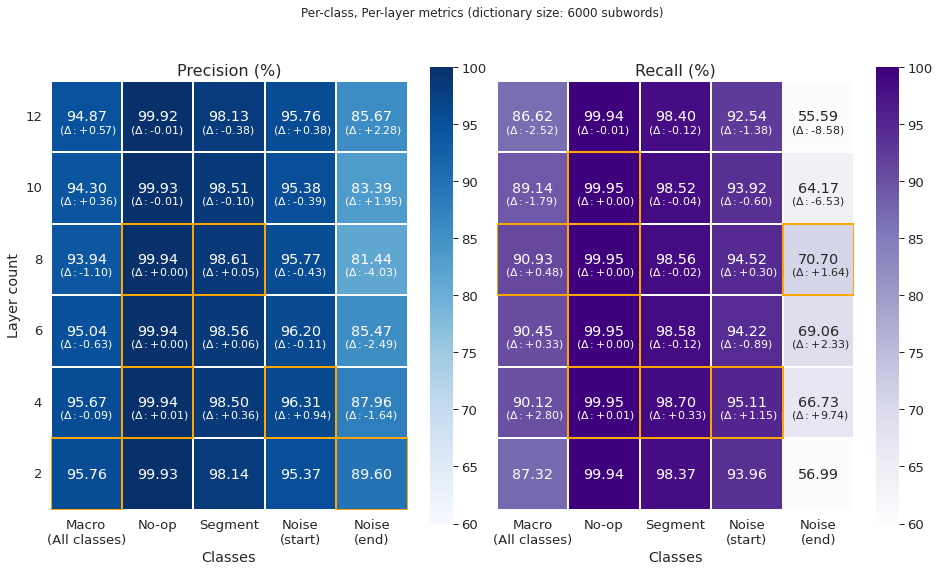

In [3]:
df_6000, _ = plot_heatmap(vocab_size=6000)

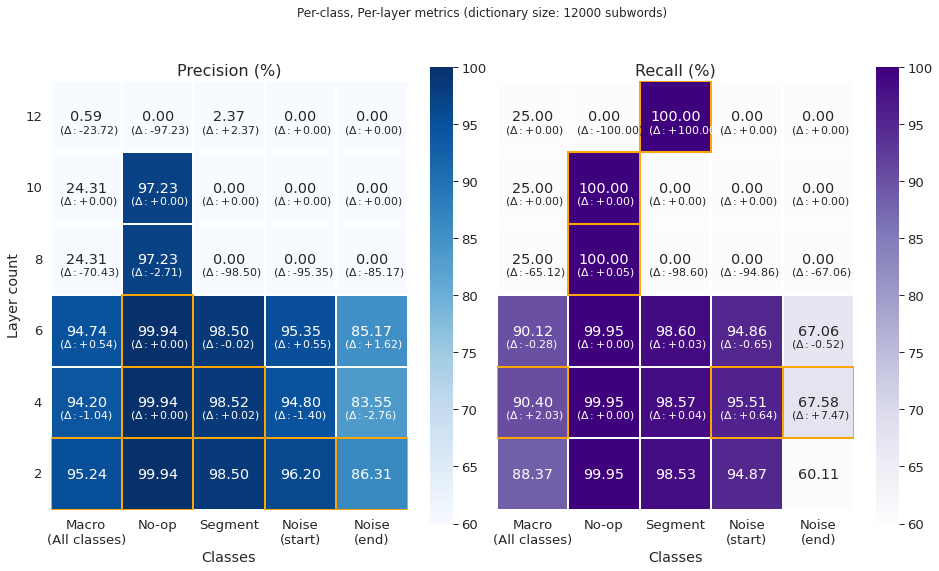

In [4]:
df_12000, _ = plot_heatmap(vocab_size=12000)

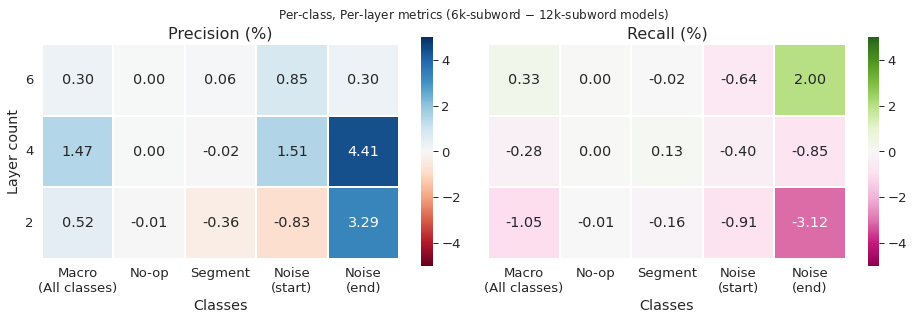

In [5]:
df_diff, _ = plot_diff_heatmap(
    df_1=df_6000,
    df_2=df_12000,
    layers=[2, 4, 6],
    save_in_disk=False,
)

# Using trained models in a few unseen examples

In [6]:
import pandas as pd
import colorama


import segmentador

%load_ext autoreload
%autoreload 2


VOCAB_SIZE = 6000


seg_model = segmentador.Segmenter(
    uri_model=f"../pretrained_segmenter_model/6_{VOCAB_SIZE}_layer_model",
    init_from_pretrained_weights=True,
    device="cpu",
    inference_pooling_operation="assymetric-max",
)

seg_model.model.config

BertConfig {
  "_name_or_path": "../pretrained_segmenter_model/6_6000_layer_model",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "NO-OP",
    "1": "SEG_START",
    "2": "NOISE_START",
    "3": "NOISE_END"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "NO-OP": 0,
    "NOISE_END": 3,
    "NOISE_START": 2,
    "SEG_START": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 1024,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "torch_dtype": "float32",
  "tr

In [7]:
df = pd.read_csv(
    "/media/hdd/master/data/proposicao-tema-extra.csv",
    header=0,
    usecols=["imgArquivoTeorPDF"],
).squeeze(True)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

non_noise_inds = [i for i, text in enumerate(df) if set("˜ˇˆˇˇˆ").isdisjoint(text)]

df = df.iloc[non_noise_inds]

print(df.shape)

(3584,)


In [ ]:
id_ = -3

segments_a = seg_model(
    df.iloc[id_],
    return_justificativa=False,
    window_shift_size=0.25,
    batch_size=4,
)

segments_b = seg_model(
    df.iloc[id_],
    return_justificativa=False,
    window_shift_size=0.25,
    batch_size=32,
)


i = j = 0
diff_a_b = set(segments_a) - set(segments_b)
diff_b_a = set(segments_b) - set(segments_a)

while i < len(segments_a) or j < len(segments_b):
    print(end=colorama.Fore.YELLOW)
    
    if i >= len(segments_a):
        print("A: --")
        print("B:", segments_b[j], end="\n\n")
        j += 1
        continue
    
    if j >= len(segments_b):
        print("A:", segments_a[i])
        print("B: --", end="\n\n")
        i += 1
        continue
    
    if segments_a[i] in diff_a_b:
        print("A:", segments_a[i])
        print("B: --", end="\n\n")
        i += 1
        continue
    
    if segments_b[j] in diff_b_a:
        print("A: --")
        print("B:", segments_b[j], end="\n\n")
        j += 1
        continue
        
    print(end=colorama.Style.RESET_ALL)
    print("A:", segments_a[i])
    print("B:", segments_b[j], end="\n\n")
    i += 1
    j += 1

In [8]:
id_ = -1
return_justificativa = True

print(colorama.Fore.RED, "+-----------------------------+", colorama.Style.RESET_ALL, sep="", end="\n")
print(colorama.Fore.RED, "|        Original Text:       |", colorama.Style.RESET_ALL, sep="", end="\n")
print(colorama.Fore.RED, "+-----------------------------+", colorama.Style.RESET_ALL, sep="", end="\n\n")

print(df.iloc[id_])

segments, justificativa = seg_model(
    df.iloc[id_],
    return_justificativa=return_justificativa,
    window_shift_size=256,
    batch_size=4,
)

print(colorama.Fore.YELLOW, "+-----------------------------+", colorama.Style.RESET_ALL, sep="", end="\n")
print(colorama.Fore.YELLOW, "|     Segmentation Result:    |", colorama.Style.RESET_ALL, sep="", end="\n")
print(colorama.Fore.YELLOW, "+-----------------------------+", colorama.Style.RESET_ALL, sep="", end="\n\n")

for i, seg in enumerate(segments, 1):
    print(f"{colorama.Fore.WHITE + str(i) + colorama.Style.RESET_ALL}: {seg}", end="\n\n")
    
print(colorama.Fore.BLUE, "+-----------------------------+", colorama.Style.RESET_ALL, sep="", end="\n")
print(colorama.Fore.BLUE, "|        Justificativa:       |", colorama.Style.RESET_ALL, sep="", end="\n")
print(colorama.Fore.BLUE, "+-----------------------------+", colorama.Style.RESET_ALL, sep="", end="\n\n")

if return_justificativa:
    print(justificativa)

+-----------------------------+
|        Original Text:       |
+-----------------------------+

             Câmara dos Deputados           PROPOSTA DE EMENDA À CONSTITUIÇÃO Nº 32, DE 2020   Emenda Substitutiva Global à PEC nº 32/2020, que altera disposições sobre servidores, empregados públicos e organização administrativa.  EMENDA SUBSTITUTIVA GLOBAL (Dos Srs. André Figueiredo, Israel Batista e outros)  AS MESAS DA CÂMARA DOS DEPUTADOS E DO SENADO FEDERAL, nos termos do §3º do art. 60 da Constituição Federal, promulgam a seguinte Emenda ao texto constitucional: Art. 1º A Constituição passa a vigorar com as seguintes alterações: Art. 37. A administração pública direta e indireta de quaisquer dos Poderes da União, dos Estados, do Distrito Federal e dos Municípios obedecerá aos princípios de legalidade, impessoalidade, moralidade, publicidade, eficiência, transparência, boa governança pública, e, também, ao seguinte:  II - a investidura em cargo ou emprego público depende de aprovação 

+-----------------------------+
|     Segmentation Result:    |
+-----------------------------+

1: Câmara dos Deputados

2: PROPOSTA DE EMENDA À CONSTITUIÇÃO Nº 32, DE 2020 Emenda Substitutiva Global à PEC nº 32 / 2020, que altera disposições sobre servidores, empregados públicos e organização administrativa. EMENDA SUBSTITUTIVA GLOBAL ( Dos Srs. André Figueiredo, Israel Batista e outros ) AS MESAS DA CÂMARA DOS DEPUTADOS E DO SENADO FEDERAL, nos termos do § 3º do art. 60 da Constituição Federal, promulgam a seguinte Emenda ao texto constitucional :

3: Art. 1º A Constituição passa a vigorar com as seguintes alterações :

4: Art. 37. A administração pública direta e indireta de quaisquer dos Poderes da União, dos Estados, do Distrito Federal e dos Municípios obedecerá aos princípios de legalidade, impessoalidade, moralidade, publicidade, eficiência, transparência, boa governança pública, e, também, ao seguinte :

5: II - a investidura em cargo ou emprego público depende de aprovação p